## Nucleus Segmentation with a pre-trained network

In this lesson we will use an already trained network to segment the nuclei based on the channel with nucleus stain. Nucleus segmentation is an important step for further analysis, for example for the full cell segmentation.

Here, we will use a pre-trained model for nucleus segmentation from [bioimage.io](https://bioimage.io/#/). It is a website that collects deep learning models for microscopy image analysis tasks. It also provides a [python library](https://github.com/bioimage-io/core-bioimage-io-python) for applying these networks to new data.
The network we will use was trained based on data from the [DSB Nucleus Segmentation Challenge](https://www.kaggle.com/c/data-science-bowl-2018), which contains training data for nucleus segmentation from different modalities.

In [35]:
# General imports.
import os
from glob import glob

import imageio.v3 as imageio
import napari
import numpy as np

from tqdm import tqdm

In [5]:
# This function will download and unpack the data and do some further data preparation.
# It will only be executed if the data has not been downloaded yet.
data_dir = "../data"
if os.path.exists(data_dir):
    print("The data is downloaded already.")
else:
    utils.prepare_data(data_dir)

The data is downloaded already.


### 1. Check the data

Let's first visualize the images for the segmentation task. Here, we will only use the nucleus channel and want to segment the individual based on it.

In [8]:
# Load one of the images from the test dataset.
image_path = os.path.join(data_dir, "test/gt_image_040/gt_image_040_nucleus_image.tif")
image = imageio.imread(image_path)

In [9]:
# Visualize it with napari
viewer = napari.Viewer()
viewer.add_image(image)

<Image layer 'image' at 0x7f5262bf86d0>

### 2. Finding a suitable model

Now we check if there is a suitable model for the our image analysis problem (nucleus segmentation from fluorescence microscopy) on [bioimage.io](https://bioimage.io/#).
We can search models by keywrod, for example we for models with the keyword nuclei `nuclei`. When you type in nuclei you should see a similar list of models as here:

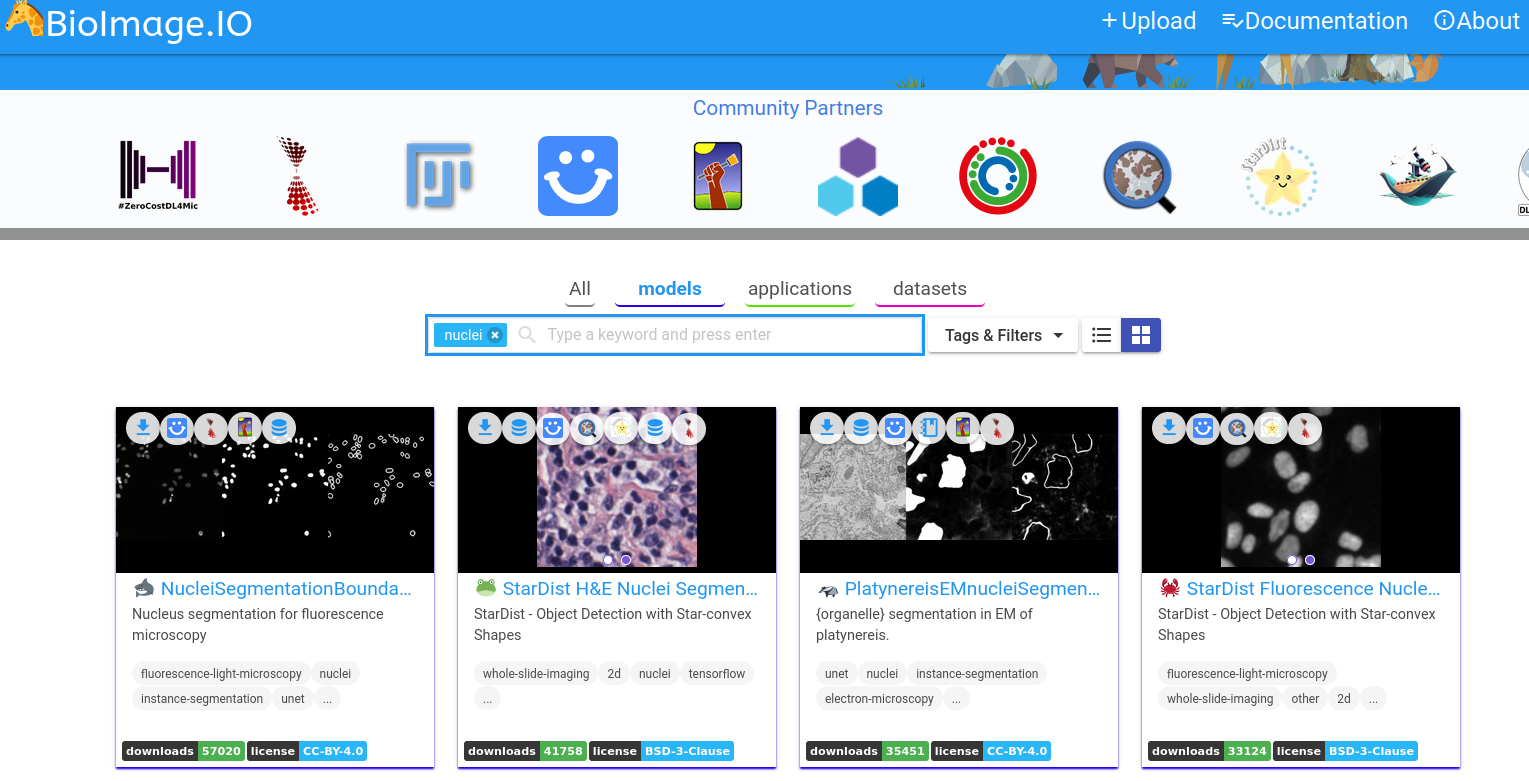

You can now click on the icons for the different models and read their descriptions to see if they could match our task.

For example, this is what you see when you click on the first model from the search above:

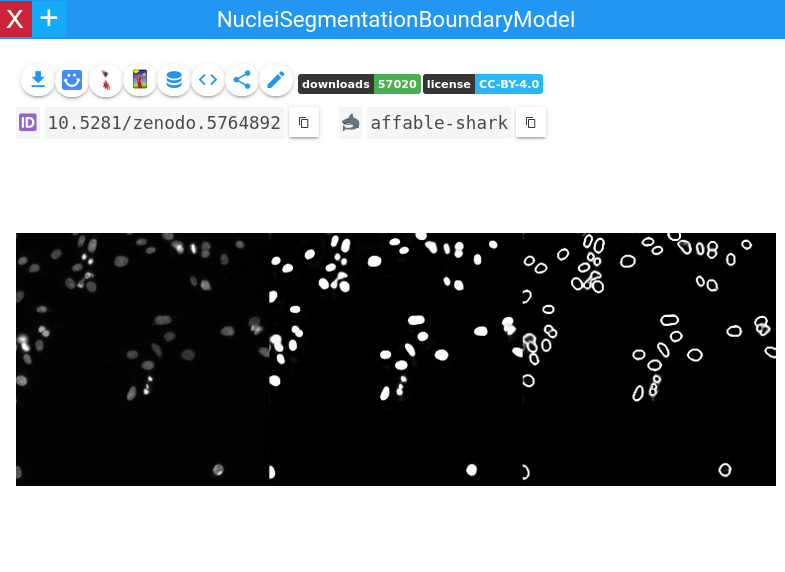

As we can see from the example image and the description, the task this model was trained for matches our problem quite well. So let's go ahead and use this model!

Each model on bioimage.io has a name that can be used for downloading it. This one is called [affable-shark](https://bioimage.io/#/?tags=nuclei&id=10.5281%2Fzenodo.5764892).

Now we will use the [bioimage.io python library](https://github.com/bioimage-io/core-bioimage-io-python) to download this model and apply it to our example image.

In [11]:
# Import the libraries for using bioimage.io models.
import bioimageio.core as bioimageio
from xarray import DataArray

In [12]:
# We first download the model. 'load_resource_description' will do this and returns a handle for the model
# that we can use in other functions of the bioimage.io library.
model_name = "affable-shark"  # nickname of the model
model = bioimageio.load_resource_description(model_name)

rdf.yaml: 4.18kiB [00:00, 3.74MiB/s]                                                                                      
/home/pape/micromamba/envs/main/lib/python3.11/site-packages/bioimageio/spec/shared/_resolve_source.py:482: UserWarning: Download (4184) does not have expected size (1612).
  warnings.warn(f"Download ({t.n}) does not have expected size ({total_size}).")
/home/pape/micromamba/envs/main/lib/python3.11/site-packages/bioimageio/spec/shared/schema.py:46: ValidationWarning: tags: Missing tags corresponding to bioimage.io categories: [{'framework': ['tensorflow', 'pytorch', 'tensorflow.js']}, {'software': ['ilastik', 'imagej', 'fiji', 'imjoy', 'deepimagej', 'napari']}, {'method': ['stardist', 'cellpose', 'yolo', 'care', 'n2v', 'denoiseg']}]
  warnings.warn(msg, category=ValidationWarning)
/home/pape/micromamba/envs/main/lib/python3.11/site-packages/bioimageio/spec/shared/schema.py:46: ValidationWarning: weights:torchscript: missing 'pytorch_version'
  warnings.warn(msg, c

### 2. Check the model

Now we run prediction with the model for the sample image and visualize the results in napari.

In [20]:
# Run prediction with the model. The bioimage.io library provides functionality called 'PredictionPipeline' for this.
# This pipeline combines three different steps necessary for applying a model to new data:
# - It applies preprocessing of the input data. This typically includes data normalization to ensure that the image
#   data is in the correct data range. This means that we don't have to take care of normalizing the image data here,
#   because the prediction pipeline will do it for us.
# - It applies the model to the input data (after it has been preprocessed).
# - It can optionally apply post-processing to the prediction.
#   For the model we have chosen no post-processing is applied and the prediction pipeline
#   will directly return the predictions.
# The prediction pipeline will also automatically make use of a GPU if it's available.

# Create the prediction pipeline for our model.
with bioimageio.create_prediction_pipeline(model) as prediction_pipeline:
    
    # The input to the model must have four dimensions:
    # A batch and channel axis and the two image axes.
    # The image data we have loaded only has the image axes, so we add two "dummy" axes in front,
    # using the 'expand_dims' function from numpy.
    input_ = np.expand_dims(image, axis=(0, 1))
    
    # After this we also need to label the axes with their name.
    # This is required by the bioimage.io library to understand the data and is done by the code below.
    input_ = DataArray(input_, dims=tuple("bcyx"))
    
    # Now we can apply the prediction pipeline.
    result = prediction_pipeline(input_)

computing dataset statistics: 0it [00:00, ?it/s]


In [21]:
# Let's check what the prediction pipeline has returned:
print("Type of the result:", type(result))

Type of the result: <class 'list'>


In [22]:
# You see that the return type is a list.
# Let's check how many elements are in there:
print(len(result))

1


In [23]:
# There's a single element in there - this is the prediction of our model.
# Why do we get back a list then?
# Because there could be more complicated outputs from models that contain different kinds of outputs.
# But here we have a rather simple prediction, let's extract it from the result:
prediction = result[0]

In [25]:
# Let's check the shape of the prediction:
print(prediction.shape)

(1, 2, 1024, 1024)


In [ ]:
# You should see that we have a shape of 1 x 2 x 1024 x 1024.
# The 1 corresponds to the batch axis and it's 1 because we ran prediction for just a single image.
# The 2 corresponds to the channel axis - so the model predicts two different channels.
# 1024 x 1024 is the image shape.

In [27]:
# So what are the two channels predicted by the model?
# Let's check this out in napari.
viewer = napari.Viewer()
viewer.add_image(image)
viewer.add_image(prediction)

/home/pape/micromamba/envs/main/lib/python3.11/site-packages/napari/plugins/_plugin_manager.py:555: UserWarning: Plugin 'napari_skimage_regionprops2' has already registered a function widget 'duplicate current frame' which has now been overwritten
  warn(message=warn_message)


<Image layer 'prediction' at 0x7f521c468a90>

You should see that the two channels correspond to predictions for:
- foreground / background: the value for each pixel encodes how likely it is to belong to a nuclues (foreground) or background.
- boundary: the value for each pixel encodes how likely it is to be on the boundary between two nuclei or not.

This is how it looks when displaying all the data side by side:

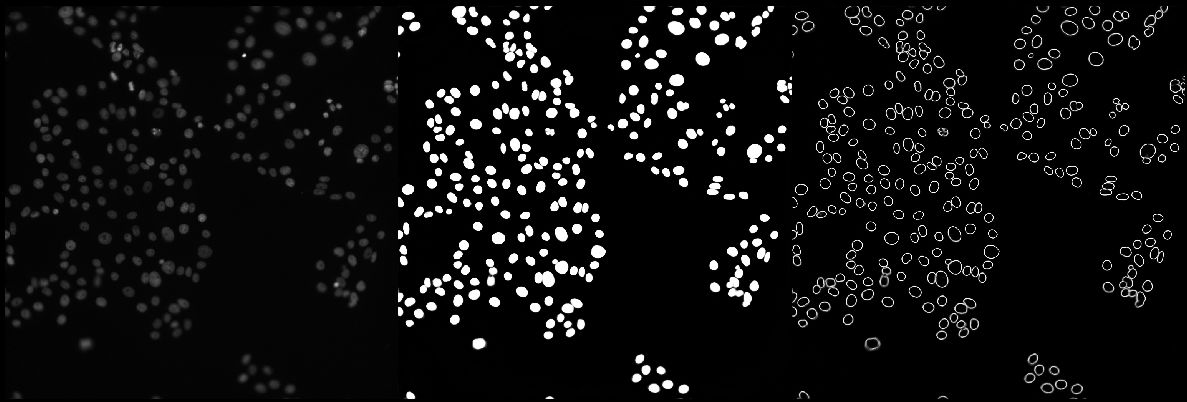

### 3. Post-processing to segment individual nuclei

As we have now seen the model predicts foreground and boundary probabilities. However, we want to segment individual nuclei.
This means we want a label mask as result, where each pixel has the value of the individual nucleus it belongs to, labeled with ids starting from 1 (up to the number of nuclei).

We can obtain this representation from the model predictions by applying connected component labeling to the predictions.
Connected components transform a binary image into a label mask, by assigning all pixels in the foreground that are connected with each other to an id.

To apply this idea to the predictions we:
- First subtract the boundary predictions from the foreground predictions, so that touching nuclei get separated from each other.
- Then threshold the resulting image to get a binary image.
- And apply connected components to this binary image to get the label mask, which is our desired result.

In [34]:
# Import the function for running connected component labeling.
from skimage.measure import label

In [31]:
# We need to change the prediction a bit further so that we can use it here
# and remove the batch axis ('[0]') and cast it to a numpy array ('.values')
prediction = prediction[0].values

In [39]:
# Implement the label post-processing described above:
# - subtract the boundary channel from the foreground channel (subtract first from second axis)
# - threshold the result @ 0.5
# - apply connected component labeling
foreground, boundaries = prediction[0], prediction[1]
nucleus_mask = foreground - boundaries
nucleus_mask = nucleus_mask > 0.5
nucleus_segmentation = label(nucleus_mask)

In [33]:
# Let's check the result in napari.
viewer = napari.Viewer()
viewer.add_image(image)
viewer.add_labels(nucleus_segmentation)

/home/pape/micromamba/envs/main/lib/python3.11/site-packages/napari/plugins/_plugin_manager.py:555: UserWarning: Plugin 'napari_skimage_regionprops2' has already registered a function widget 'duplicate current frame' which has now been overwritten
  warn(message=warn_message)


<Labels layer 'nucleus_segmentation' at 0x7f521ceb6b10>

You should see the label mask overlaid with the image in napari. The segmented nuclei should match the label data well.

### 4. Run prediction for all test imaes and evaluate it

We now apply the segmentation procedure we developed to all images from the test split and will also evaluate the quality of the segmentation.

In [36]:
# We create a folder where we can save the nucleus predictions.
# We can then re-use these predictions in other exercises.
output_folder = os.path.join(data_dir, "predictions", "nuclei")
os.makedirs(output_folder, exist_ok=True)

In [40]:
# Get all the images for the nucleus channel in the test images.
input_files = glob(os.path.join(data_dir, "test", "gt_*", "*_nucleus_image.tif"))

In [44]:
# We now define a function that applies the model for an image
# and then applies the connected component labeling.
def run_segmentation(prediction_pipeline, image):
    # Bring the input into the correct format for bioimageio.
    input_ = DataArray(np.expand_dims(image, axis=(0, 1)), dims=tuple("bcyx"))

    # Apply the model. Here, we use prediction with padding to deal with images
    # that have a shape that is not compatible with the model.
    # The function 'predict_with_padding' automatically pads these to a shape that
    # can be used by the model and removes this padding after the prediction.
    prediction = bioimageio.predict_with_padding(prediction_pipeline, input_, padding=True)
    # Bring the prediction to the correct data format.
    prediction = prediction[0][0].values

    # Apply the pos-processing to get a segmentation mask.
    foreground, boundaries = prediction[0], prediction[1]
    nucleus_mask = foreground - boundaries
    nucleus_mask = nucleus_mask > 0.5
    nucleus_segmentation = label(nucleus_mask)
    
    return nucleus_segmentation

In [47]:
# Run segmentation for all the test images.
with bioimageio.create_prediction_pipeline(model) as prediction_pipeline:
    # We add a progress bar to know how long it will take.
    for path in tqdm(input_files, desc="Run nucleus segmentation"):
        image = imageio.imread(path)
        segmentation = run_segmentation(prediction_pipeline, image)

        # We save the segmentation as a compressed tif, using a filename that matches the input name.
        filename = os.path.basename(path)
        output_path = os.path.join(output_folder, filename)
        imageio.imwrite(output_path, segmentation, compression="zlib")

computing dataset statistics: 0it [00:00, ?it/s]
Run nucleus segmentation: 100%|█████████████████████████████████████████████████████████████| 9/9 [01:04<00:00,  7.21s/it]


In [48]:
# Now we evaluate the quality of the segmentation.
# For this, we use an intersection-over-union derived metric.
# It matches objects in the segmentation with objects in the ground-truth (the 'true' segmentation).
# It counts objects matched with more than 50% overlap as matched correctly and computes the F1-Score (or other statistics)
# based on this matching.

# Import the metric.
from elf.evaluation import matching

In [49]:
# Get the paths to the predictions and to the ground-truth segmentation.
segmentation_files = sorted(glob(os.path.join(output_folder, "gt_*.tif")))
gt_files = sorted(glob(os.path.join(data_dir, "test", "gt_*", "*_nucleus_labels.tif")))
assert len(segmentation_files) == len(gt_files)

In [51]:
# Run evaluation for all of them.
f1_scores = []
for seg_file, gt_file in zip(segmentation_files, gt_files):
    segmentation = imageio.imread(seg_file)
    gt = imageio.imread(gt_file)
    f1_score = matching(segmentation, gt)["f1"]
    f1_scores.append(f1_score)

print("The average F1-score is", np.mean(f1_scores))

The average F1-score is 0.9352735447349299


### Exercises

**TODO:** work on the exercises.

Possible exercises:
- Use a watershed based post-processing instead, find good hyperparameter on the validation set and compare to the previous result on test.
    - See the sketch for the watershed based post-processing below.
- Apply [stardist](https://github.com/stardist/stardist) instead, evaluate it and to compare to our result here.
    - See `stardist_pretrained-nucleus-segmentation` notebook (not yet done).
 
Note: there are several other deep learning based tools for nucleus segmentation. In particular,  is a versatile and robust choice for this task. The notebook  demonstrates how to use it for nucleus segmentation on our data. 

**Sketch for watershed based post-processing:**

As you have seen the model predicts foreground and nucleus boundaries. However, we want to segment individual nuclei, i.e. an "image" where each nucleus is marked by an unique id. So we post-process the network predictions to get the instance segmentation:
- compute the distance map to the boundary predictions
- set it to zero outside of the predicted foreground
- find the distance maxima
- run seeded watershed from these maxima using the boundary predictions as height map

We choose this approach in order to separate touching nuclei with weak boundary evidence.

In [ ]:
# the functions from scipy and skimage we need to implement the instance segmentation procedure
from scipy.ndimage import distance_transform_edt
from skimage.feature import peak_local_max
from skimage.filters import gaussian
from skimage.segmentation import watershed

In [ ]:
# compute the distances to nearest boundaries inside the predicted foreground
foreground, boundaries = prediction
foreground = foreground > 0.5
boundary_distances = distance_transform_edt(boundaries < 0.1)
boundary_distances[~foreground] = 0
boundary_distances = gaussian(boundary_distances)

In [ ]:
# find the seeds (= maxima of the distance map) and run seeded watershed
seed_points = peak_local_max(boundary_distances, min_distance=5, exclude_border=False)
seeds = np.zeros(foreground.shape, dtype="uint32")
seeds[seed_points[:, 0], seed_points[:, 1]] = np.arange(1, len(seed_points) + 1)
nucleus_segmentation = watershed(boundaries, markers=seeds, mask=foreground)

In [ ]:
# check the segmentation result and visualize the intermediates
viewer = napari.Viewer()
viewer.add_image(image)
viewer.add_image(boundaries)
viewer.add_image(boundary_distances)
viewer.add_points(seed_points)
viewer.add_labels(nucleus_segmentation)